In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
%cd ~/PycharmProjects/pqr/
from pqr.factors import (
    # single factors
    PickingFactor, WeightingFactor, FilteringFactor, 
    # multi-factors
    InterceptMultiFactor, NSortMultiFactor, WeighMultiFactor
)
from pqr.factor_model import FactorModel
from pqr.benchmarks import Benchmark

from pqr.preprocessing import correct_matrices

/home/akbabkin/PycharmProjects/pqr


## Считываем данные

In [3]:
prices = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/price.xlsx', index_col=0, parse_dates=True)
index = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/benchmark.xlsx', index_col=0, parse_dates=True)

pe = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/mults/pe.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/financials/market_cap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('/home/akbabkin/notebooks/summer_school/data/liquidity/volume.xlsx', index_col=0, parse_dates=True)

In [4]:
# корреткируем матрицы (сортировка + удаление лишних колонок и индексов)
prices, pe, mcap, volume = correct_matrices(prices, pe, mcap, volume)

## Создаем на основе данных факторы с дефолтными параметрами. 
Конструктор принимает на вход параметры:
* data: Union[numpy.ndarray, pandas.core.frame.DataFrame],
* dynamic: bool = False,
* bigger_better: bool = True,
* name: str = None,

In [5]:
# основной фактор на основе P/E + фактор на основе капитализации (для мультифакторных моделей)
value = PickingFactor(pe, bigger_better=False, name='value')
size = PickingFactor(mcap, bigger_better=False, name='size')
# фильтрующий фактор на основе среднедневного объема (те же параметры, что и для основного + пороги)
liquidity = FilteringFactor(volume, min_threshold=1_000_000, name='liquidity')
# взвешивающий фактор на основе капитализации
size_w = WeightingFactor(mcap, name='size_weighting')

# бенчмарк уже готовый
benchmark = Benchmark(index['CLOSE'], name='FTSE_MIB')

In [6]:
value

PickingFactor(value)

In [7]:
liquidity

FilteringFactor(liquidity)

In [8]:
size_w

WeightingFactor(size_weighting)

In [9]:
benchmark

Benchmark(FTSE_MIB)

## Создаем фаткорную модель
Конструктор принимает на вход параметры:
* looking_period: int = 1,
* lag_period: int = 0,
* holding_period: int = 1,

In [10]:
fm = FactorModel(3, 0, 3)

## "Обучаем" факторную модель.
Она принимает на вход:
* prices: pandas.core.frame.DataFrame,
* factor: pqr.factors.interfaces.ipicking.IPicking,
* filtering_factor: pqr.factors.interfaces.ifiltering = None,
* weighting_factor: pqr.factors.interfaces.iweighting = None,
* benchmark: pqr.benchmarks.interfaces.ibenchmark.IBenchmark = None,
* n_quantiles: int = 3,
* add_wml: bool = False

In [11]:
fm.fit(
    prices=prices,
    picking_factor=value,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark,
    n_quantiles=3,
    add_wml=True
)

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [12]:
fm.portfolios

(Portfolio(Quantiles(0.00, 0.33)),
 Portfolio(Quantiles(0.33, 0.67)),
 Portfolio(Quantiles(0.67, 1.00)),
 WMLPortfolio())

In [13]:
fm.portfolios[0].returns

2016-01-31    0.000000
2016-02-29    0.000000
2016-03-31    0.000000
2016-04-30    0.000000
2016-05-31   -0.061200
                ...   
2020-12-31   -0.013616
2021-01-31   -0.045141
2021-02-28    0.162105
2021-03-31    0.105580
2021-04-30    0.001591
Length: 64, dtype: float64

In [14]:
fm.portfolios[0].alpha

Alpha(coef=-0.006467396264411493, p_value=0.14842032233148728)

In [15]:
fm.portfolios[0].returns

2016-01-31    0.000000
2016-02-29    0.000000
2016-03-31    0.000000
2016-04-30    0.000000
2016-05-31   -0.061200
                ...   
2020-12-31   -0.013616
2021-01-31   -0.045141
2021-02-28    0.162105
2021-03-31    0.105580
2021-04-30    0.001591
Length: 64, dtype: float64

In [16]:
fm.portfolios[0].positions

,1913.HK,A2.MI,ACE.MI,AMPF.MI,ATL.MI,ATMI.MI,AZMT.MI,BAMI.MI,BCU.MI,BGN.MI,...,RACE.MI,RECI.MI,REY.MI,SFER.MI,SRG.MI,TGYM.MI,TLIT.MI,TRN.MI,UNPI.MI,US.MI
2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2016-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2021-01-31,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2021-02-28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2021-03-31,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [17]:
fm.portfolios[0].sharpe

0.025108798475755343

In [18]:
fm.portfolios[0].max_drawdown

-0.5470737763165131

In [19]:
fm.portfolios[0].stats

{'Alpha, %': -0.6467396264411494,
 'Alpha p-value': 0.14842032233148728,
 'Beta': 1.391076748691044,
 'Beta p-value': 2.6136906720951966e-27,
 'Sharpe Ratio': 0.025108798475755343,
 'Mean Return, %': 0.2267605454132725,
 'Excessive Return, %': -0.38008693862829285,
 'Total Return, %': -11.204386141883415,
 'Volatility, %': 9.031118937540118,
 'Benchmark Correlation': 0.9237438695545731,
 'Profitable Periods, %': 46.875,
 'Maximum Drawdown, %': -54.70737763165131}

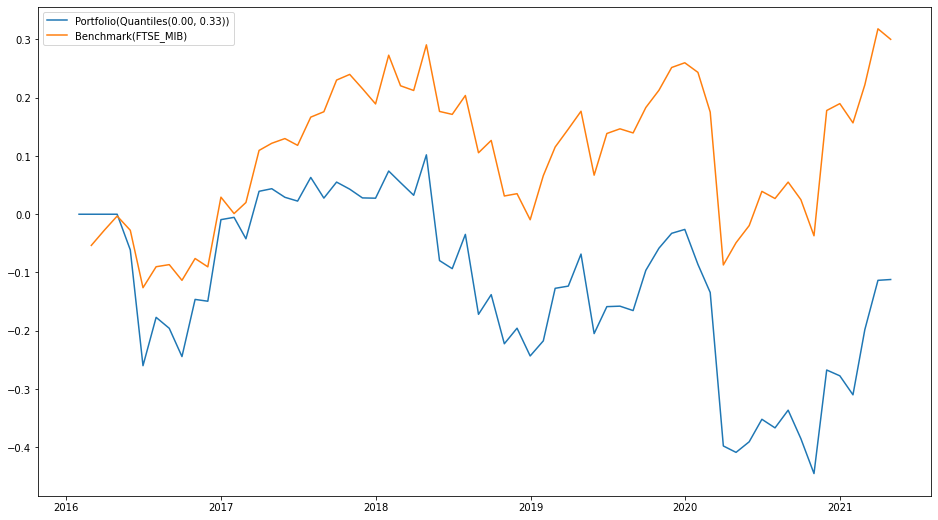

In [20]:
fm.portfolios[0].plot_cumulative_returns(add_benchmark=True)
plt.legend()

## Сравниваем портфели 
tabulate пришлось убрать, поскольку при отрисовке больше 3 портфелей у меня слетало форматирование из-за того, что вывод не помещался. Пока временно сделал табличку с помощью пандаса

,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))",WMLPortfolio()
"Alpha, %",-0.65,0.17,-0.05,-0.56
Alpha p-value,0.15,0.68,0.91,0.42
Beta,1.39,0.85,0.84,0.54
Beta p-value,0.00,0.00,0.00,0.00
Sharpe Ratio,0.03,0.11,0.08,-0.04
"Mean Return, %",0.23,0.67,0.46,-0.23
"Excessive Return, %",-0.38,0.06,-0.15,-0.84
"Total Return, %",-11.20,37.07,19.57,-24.12
"Volatility, %",9.03,5.97,5.99,6.36
Benchmark Correlation,0.92,0.85,0.84,0.52


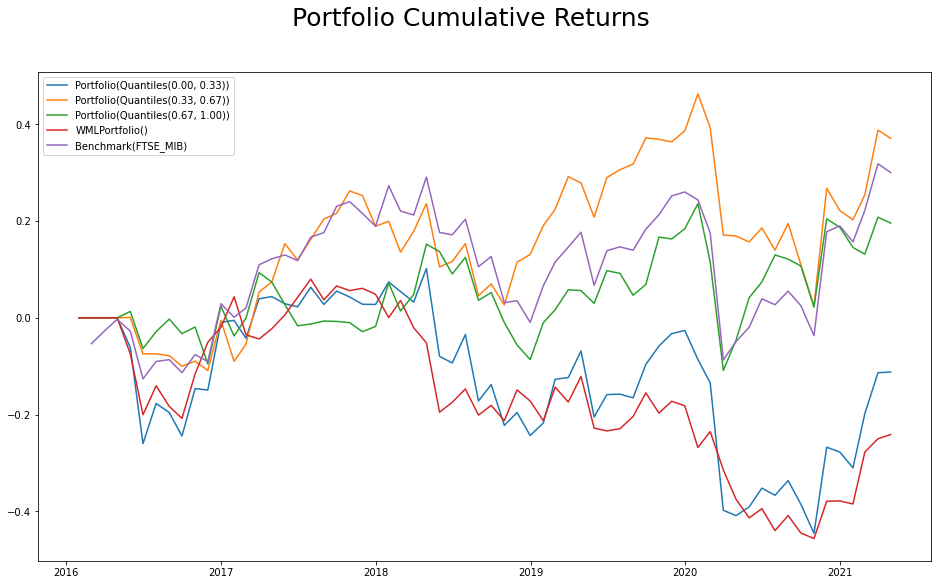

In [21]:
fm.compare_portfolios()

## Мультифакторы
Мультифактор принимает на вход список факторов класса Factor и name: str по умолчанию, но WeightedMultiFactor, также принимает список весов для каждого фактора (необязательно в сумме должны быть равны 1, т.к. внутри происходит нормировка, но все значения должны быть больше нуля)

### ! Важно: 
Мультифактор может содержать разнородные факторы (например, low_volatility и quality: от волатильности мы хотим наименьшее значение (bigger_better=False), а от quality - наибольшее (bigger_better=True)). 

В таком случае квантили для NSort и Intercept строятся относительно bigger_better: то есть если я хочу построить портфель на основе квантилей (0.8; 1), то это значит, что я беру (0.8, 1) по quality и (0, 0.2) по low_volatility (автоматически происходит "отзеркаливание" квантиля для фактора с bigger_better=False).

Если все факторы однородные (либо bigger_better=False для всех, либо bigger_better=True для всех), то портфель строится именно по тем квантилям, которые переданы.

Порядок передачи факторов также важен: для NSort мы сначала сортируем по 1 фактору, потом по 2 и т.д. (передавать можно сколько угодно факторов во все мультифакторы).

In [22]:
intercept = InterceptMultiFactor([value, size], name='intercept_value+size')
nsort = NSortMultiFactor([value, size], name='2sort_value+size')
weighted = WeighMultiFactor([value, size], weights=[0.3, 0.7], name='weighted_value+size')

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))"
"Alpha, %",-0.07,0.08,-0.24
Alpha p-value,0.93,0.89,0.68
Beta,1.47,0.62,0.90
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.08,0.08,0.04
"Mean Return, %",0.81,0.45,0.31
"Excessive Return, %",0.21,-0.16,-0.30
"Total Return, %",14.88,19.70,4.46
"Volatility, %",10.82,5.75,6.93
Benchmark Correlation,0.82,0.64,0.78


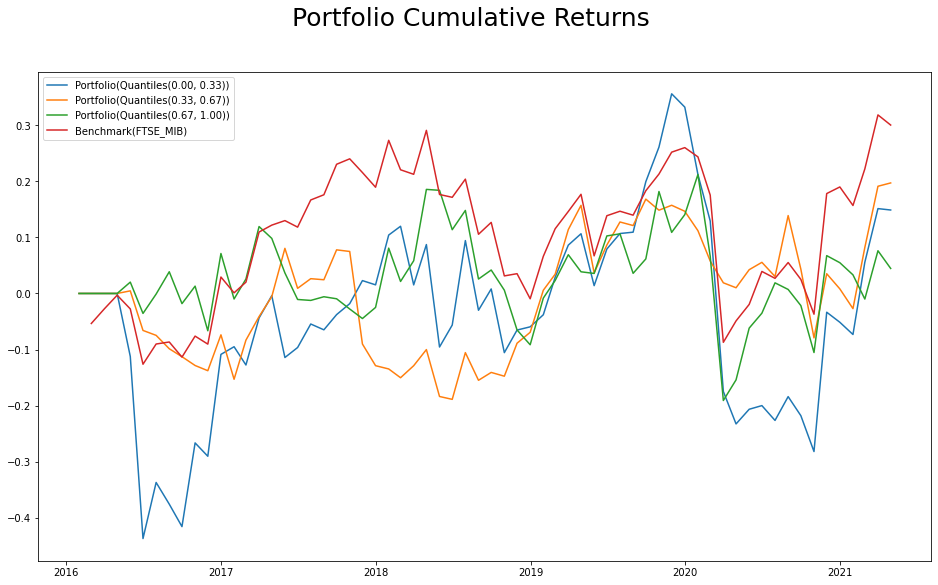

In [23]:
fm.fit(
    prices=prices,
    picking_factor=intercept,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark
)
fm.compare_portfolios()

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))"
"Alpha, %",-0.77,-0.35,-0.59
Alpha p-value,0.30,0.43,0.33
Beta,1.47,0.95,1.03
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.02,0.04,0.01
"Mean Return, %",0.16,0.24,0.06
"Excessive Return, %",-0.45,-0.36,-0.54
"Total Return, %",-22.59,1.19,-13.59
"Volatility, %",10.41,6.61,7.67
Benchmark Correlation,0.84,0.86,0.81


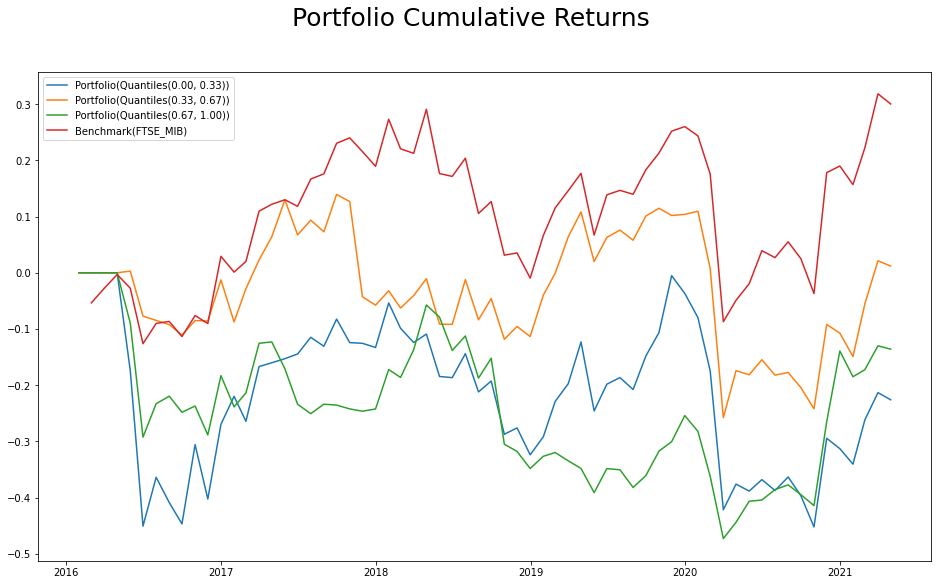

In [24]:
fm.fit(
    prices=prices,
    picking_factor=nsort,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark,
)
fm.compare_portfolios()

/home/akbabkin/notebooks/.datascience/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))"
"Alpha, %",0.17,0.11,-0.45
Alpha p-value,0.71,0.71,0.07
Beta,1.09,0.86,1.03
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.11,0.11,0.03
"Mean Return, %",0.81,0.62,0.19
"Excessive Return, %",0.21,0.01,-0.41
"Total Return, %",41.04,34.29,-0.89
"Volatility, %",7.42,5.64,6.48
Benchmark Correlation,0.88,0.91,0.95


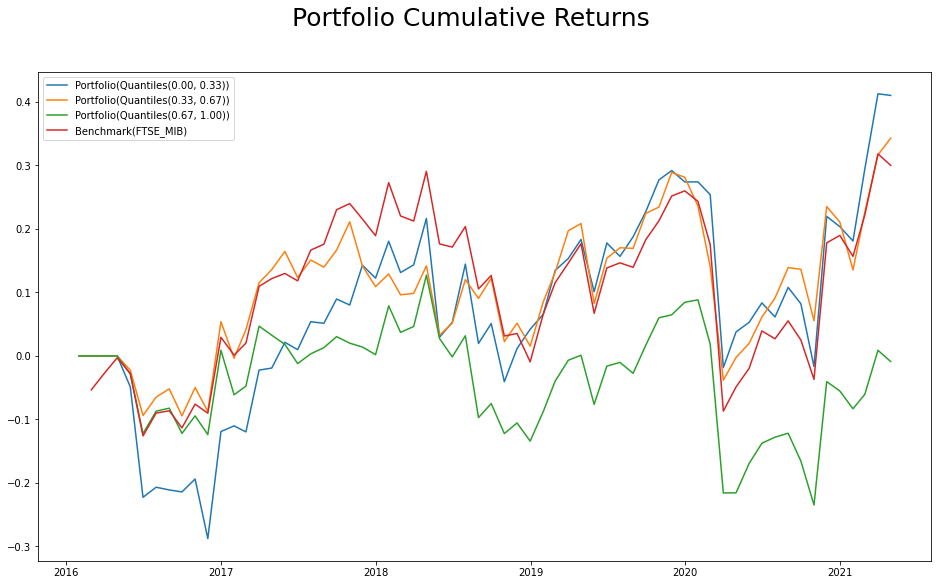

In [25]:
fm.fit(
    prices=prices,
    picking_factor=weighted,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark
)
fm.compare_portfolios()

## grid_search
Метод класса FactorModel - принимает на вход сначала 3 списка/массива/чего угодно, по чему можно итерироваться; дальше все параметры повторяют параметры метода fit(). Возвращает словарь, в котором ключ - кортеж вида (1, 0, 1) - это, соответственно, looking_period, lag_period, holding_period, а значение - датафрейм с результатами (такой же, как и compare_portfolios()). 

Пока без распараллеливания работает неплохо: перебор всех адекватных параметров (50 комбинаций) занял всего 2.6 секунды, но и данные у меня не очень большие. Если возникнут проблемы со скоростью/памятью на реальных задачах - распараллелю (после рефакторинга это стало возможным).

In [26]:
%%time
%%capture

results = fm.grid_search(
    looking_periods=[1, 3, 6, 9, 12],
    lag_periods=[0, 1],
    holding_periods=[1, 3, 6, 9, 12],
    prices=prices,
    picking_factor=value,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark
)

CPU times: user 4.83 s, sys: 2.2 ms, total: 4.83 s
Wall time: 4.84 s


In [27]:
results[(1, 0, 1)]

,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))"
"Alpha, %",-0.74,-0.03,0.02
Alpha p-value,0.09,0.93,0.97
Beta,1.41,0.86,0.82
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.03,0.09,0.10
"Mean Return, %",0.25,0.55,0.58
"Excessive Return, %",-0.36,-0.06,-0.03
"Total Return, %",-11.11,27.19,29.10
"Volatility, %",9.15,5.92,6.03
Benchmark Correlation,0.93,0.87,0.82


In [28]:
results[(12, 0, 12)]

,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))"
"Alpha, %",-0.24,0.76,-0.58
Alpha p-value,0.60,0.08,0.16
Beta,1.31,0.90,0.70
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.07,0.20,-0.01
"Mean Return, %",0.55,1.12,-0.06
"Excessive Return, %",-0.05,0.51,-0.67
"Total Return, %",17.16,83.44,-10.53
"Volatility, %",7.87,5.72,4.69
Benchmark Correlation,0.86,0.81,0.77
